# Computing flows with the finite difference model

*Prof. dr.ir.T.N.Olsthoorn*

*Heemstede, Sept. 2016*

## Adding flows to the output of fdm3

Until now, the 3D finite difference model was used to compute only the heads in the cell centers. It should, however been clear that the model has all the information on board to also compute the flows. In fact, each line in the system matrix is a cell's water balance and computes flows over all faces of the cell in question including the total net inflow of each cell. The equation

$ Q_x = -C_x \times \,\, diff (Phi, axis=1) $

is the flow across all cell faces perpendicular to the `x-axis`. Likewise

$ Q_y = +C_y \times \, \, diff (Phi, axis=0) $

is the flow across all cell faces perpendicular to the `y-axis` in direction of this axis, and

$ Q_z = +C_z \times \, \, diff(Phi, axis=2) $

is the upward vertical flow

In fact, we can readily compute these flow across cell faces within our model as is shown below.

We can also compute the total net inflow of all individual cells from the matrix multiplication

$ Q = A \times \Phi $

where `A` is the system matrix with the conductances and $\Phi$ is the complete vector of heads, including the fixed heads, as all computed and prescribed heads are known after the model has been solved.

## Flow output of the model

Because we have all the information to compute all flows at our disposition inside the function when computing the heads, we can, and perhaps should, at the same time compute these important flow arrays:

* `Q`  : ndarray shape (`Ny`, `Nx`  , `Nz`) [L3/T]  # total net inflow of cells
* `Qx` : ndarray shape (`Ny`, `Nx`-1, `Nz`) [L3/T]  # flow across cell faces in `x`-direction
* `Qy` : ndarray shape (`Ny`-1, `Nx`, `Nz`) [L3/T]  # flow across cell faces in `y`-direction
* `Qz` : ndarray shape (`Ny`, `Nx`, `Nz`-1) [L3/T]  # flow across cell faces in `z`-direction

We gather the computed arrays of `Phi`, `Q`, `Qx`, `Qy` and `Qz` in an single `named tuple` output named `Out`, from which the individual arrays may be addressed by their name like so:

`Out.Phi`, `Out.Q`, `Out.Qx`, `Out.Qy` and `Out.Qz`

### Flows in the cell centers

The flows at across the cell iterfaces and the net inflow for each cell is uniquely defined by the equations given above. But this is not true for the velocity or specific discharge, because the cell face area jumps at the cell itnerface. So we mat have a different specific discharge perpendicular to the cell face just to the right and to the left of it.

Therefore, such specific discharge (the Darcy velocity) are generally computed for the cell centers by averaging the total flow at two opposite cell faces and deviding by the cross section perpendicular to the cell face. This vector is unique, yet not completely defined for the case when we also have an extraction in the cell. But this does not geneally or necessarly disturb the picture of velocity vectors much. So we will use this method further down.

We have written a function `quivdata` to extract the necessary coordinates and flows or velocities for displaying them as arrows with the matplotlib function `quiver`, see example further down.


### Some more additions been made to the model:

- Applying the function `unique` to `x`, `y` and `z` input vectors to prevent duplicates. The function unique is defined in the module `fdm`. It allows entering coordinates in arbitrary order as they will be sorted and double values will be eliminated according to some user definable tolerance.

- Keeping track of the axis directions. We demand that `x` must be ascending, while `y` and `z` must be descending. This way columns (x) run from left to right when printing, the top row is the one with the largest `y`-coordinate and the top layer is the one with the highest `z`-coordinate. Enforcing these directions make interpreting scrolled or printed output intuitive and ensures the correct sign of flows. That is, a postive `Qx`, `Qy` and `Qz` always points into the direction of higher coordinates.

The adapted model is shown below.


## fdm3 model with computation of flows

The model `fdm3` is written to the module `fdm.py` together with the functions `quivdata` and `unique`

In [1]:
%%writefile fdm_b.py

import numpy as np
import pdb
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve # to use its short name
from collections import namedtuple

class InputError(Exception):
    pass

def quivdata(Out, x, y, z=None, iz=0):
    """Returns coordinates and velocity components to show velocity with quiver
    
    Compute arrays to display velocity vectors using matplotlib's quiver.
    The quiver is always drawn in the xy-plane for a specific layer. Default iz=0
    
    Parameters
    ----------
    `Out` : namedtuple holding arrays `Qx`, `Qy`, `Qz` as defined in `fdm3`
        `Qx` : ndarray, shape: (Ny, Nx-1, Nz), [L3/T]
            Interfacial flows in finite difference model in x-direction from `fdm3'
        `Qy` : ndarray, shape: (Ny-1, Nx, Nz), [L3/T]
            Interfacial flows in finite difference model in y-direction from `fdm3`
        `Qz` : ndarray, shape: (Ny, Nx, Nz-1), [L3/T]
            Interfacial flows in finite difference model in z-direction from `fdm3`            
    `x` : ndarray, [m]
        Grid line coordinates of columns
    'y' : ndarray, [m]
        Grid line coordinates of rows
    `z` : ndaray [L] | int [-]
        If z == None, then iz must be given (default = 0)
        If z is an ndarray vector of floats
            z will be interpreted as the elvations of uniform layers.
            iz will be ignored
        If z is a full 3D ndarray of floats
            z will be interpreted as the elevations of the tops and bottoms of all cells.
            iz will be ignored
    `iz` : int [-]
            iz is ignored if z ~= None
            iz is the number of the layer for which the data are requested,
            and all output arrays will be 2D for that layer.

    Returns
    -------
    `Xm` : ndarray, shape: (Nz, Ny, Nx), [L]
        x-coordinates of cell centers
    `Ym` : ndarray, shape: (Nz, Ny, Nx), [L]
        y-coodinates of cell centers
    `ZM` : ndarray, shape: (Nz, Ny, Nx), [L]
        `z`-coordinates at cell centers
    `U` : ndarray, shape: (Nz, Ny, Nx), [L3/d]
        Flow in `x`-direction at cell centers
    `V` : ndarray, shape: (Nz, Ny, Nx), [L3/T]
        Flow in `y`-direction at cell centers
    `W` : ndarray, shape: (Nz, Ny, Nx), [L3/T]
        Flow in `z`-direction at cell centers.
    
    """
    Ny = len(y)-1
    Nx = len(x)-1
    
    xm = 0.5 * (x[:-1] + x[1:])
    ym = 0.5 * (y[:-1] + y[1:])
    
    X, Y = np.meshgrid(xm, ym) # coordinates of cell centers
    
    # Flows at cell centers
    U = np.concatenate((Out.Qx[iz, :, 0].reshape((1, Ny, 1)), \
                        0.5 * (Out.Qx[iz, :, :-1].reshape((1, Ny, Nx-2)) +\
                               Out.Qx[iz, :, 1: ].reshape((1, Ny, Nx-2))), \
                        Out.Qx[iz, :, -1].reshape((1, Ny, 1))), axis=2).reshape((Ny,Nx))
    V = np.concatenate((Out.Qy[iz, 0, :].reshape((1, 1, Nx)), \
                        0.5 * (Out.Qy[iz, :-1, :].reshape((1, Ny-2, Nx)) +\
                               Out.Qy[iz, 1:,  :].reshape((1, Ny-2, Nx))), \
                        Out.Qy[iz, -1, :].reshape((1, 1, Nx))), axis=1).reshape((Ny,Nx))
    return X, Y, U, V


def unique(x, tol=0.0001):
    """return sorted unique values of x, keeping ascending or descending direction"""
    if x[0]>x[-1]:  # vector is reversed
        x = np.sort(x)[::-1]  # sort and reverse
        return x[np.hstack((np.diff(x) < -tol, True))]
    else:
        x = np.sort(x)
        return x[np.hstack((np.diff(x) > +tol, True))]

    
def fdm3(x, y, z, kx, ky, kz, FQ, HI, IBOUND):
    '''Steady state 3D Finite Difference Model returning computed heads and flows.
        
    Heads and flows are returned as 3D arrays as specified under output parmeters.
    
    Parameters
    ----------
    `x` : ndarray,[L]
        `x` coordinates of grid lines perpendicular to rows, len is Nx+1
    `y` : ndarray, [L]
        `y` coordinates of grid lines along perpendicular to columns, len is Ny+1
    `z` : ndarray, [L]
        `z` coordinates of layers tops and bottoms, len = Nz+1
    `kx`, `ky`, `kz` : ndarray, shape: (Ny, Nx, Nz), [L/T]
        hydraulic conductivities along the three axes, 3D arrays.
    `FQ` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        prescrived cell flows (injection positive, zero of no inflow/outflow)
    `IH` : ndarray, shape: (Ny, Nx, Nz), [L]
        initial heads. `IH` has the prescribed heads for the cells with prescribed head.
    `IBOUND` : ndarray, shape: (Ny, Nx, Nz) of int
        boundary array like in MODFLOW with values denoting
        * IBOUND>0  the head in the corresponding cells will be computed
        * IBOUND=0  cells are inactive, will be given value NaN
        * IBOUND<0  coresponding cells have prescribed head
    
    outputs
    -------    
    `Out` : namedtuple containing heads and flows:
        `Out.Phi` : ndarray, shape: (Ny, Nx, Nz), [L3/T] 
            computed heads. Inactive cells will have NaNs
        `Out.Q`   : ndarray, shape: (Ny, Nx, Nz), [L3/T]
            net inflow in all cells, inactive cells have 0
        `Out.Qx   : ndarray, shape: (Ny, Nx-1, Nz), [L3/T] 
            intercell flows in x-direction (parallel to the rows)
        `Out.Qy`  : ndarray, shape: (Ny-1, Nx, Nz), [L3/T] 
            intercell flows in y-direction (parallel to the columns)
        `Out.Qz`  : ndarray, shape: (Ny, Nx, Nz-1), [L3/T] 
            intercell flows in z-direction (vertially upward postitive)
        the 3D array with the final heads with `NaN` at inactive cells.
    
    TO 160905
    '''

    # define the named tuple to hold all the output of the model fdm3
    Out = namedtuple('Out',['Phi', 'Q', 'Qx', 'Qy', 'Qz'])
    Out.__doc__ = """fdm3 output, <namedtuple>, containing fields Phi, Qx, Qy and Qz\n \
                    Use Out.Phi, Out.Q, Out.Qx, Out.Qy and Out.Qz"""                            

    x = unique(x)
    y = unique(y)[::-1]  # unique and descending
    z = unique(z)[::-1]  # unique and descending
        
    # as well as the number of cells along the three axes
    SHP = Nz, Ny, Nx = len(z)-1, len(y)-1, len(x)-1
    
    Nod = np.prod(SHP)
 
    if Nod == 0:
        raise AssetError(
            "Grid shape is (Ny, Nx, Nz) = {0}. Number of cells in all 3 direction must all be > 0".format(SHP))
                                
    if kx.shape != SHP:
        raise AssertionError("shape of kx {0} differs from that of model {1}".format(kx.shape,SHP))
    if ky.shape != SHP:
        raise AssertionError("shape of ky {0} differs from that of model {1}".format(ky.shape,SHP))
    if kz.shape != SHP:
        raise AssertionError("shape of kz {0} differs from that of model {1}".format(kz.shape,SHP))
        
    # from this we have the width of columns, rows and layers
    dx = np.abs(np.diff(x)).reshape(1, 1, Nx)
    dy = np.abs(np.diff(y)).reshape(1, Ny, 1)
    dz = np.abs(np.diff(z)).reshape(Nz, 1, 1)
    
    active = (IBOUND>0).reshape(Nod,)  # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND<0).reshape(Nod,)  # boolean vector denoting fixed-head cells

    # half cell flow resistances
    Rx = 0.5 * dx / (dy * dz) / kx
    Ry = 0.5 * dy / (dz * dx) / ky
    Rz = 0.5 * dz / (dx * dy) / kz
    
    # set flow resistance in inactive cells to infinite
    Rx = Rx.reshape(Nod,); Rx[inact] = np.Inf; Rx=Rx.reshape(SHP)
    Ry = Ry.reshape(Nod,); Ry[inact] = np.Inf; Ry=Ry.reshape(SHP)
    Rz = Rz.reshape(Nod,); Rz[inact] = np.Inf; Rz=Rz.reshape(SHP)
    
    # conductances between adjacent cells
    Cx = 1 / (Rx[:, :, :-1] + Rx[:, :, 1:])
    Cy = 1 / (Ry[:, :-1, :] + Ry[:, 1:, :])
    Cz = 1 / (Rz[:-1, :, :] + Rz[1:, :, :])
    
    NOD = np.arange(Nod).reshape(SHP)
    
    IE = NOD[:, :, 1:]  # east neighbor cell numbers
    IW = NOD[:, :, :-1] # west neighbor cell numbers
    IN = NOD[:, :-1, :] # north neighbor cell numbers
    IS = NOD[:, 1:, :]  # south neighbor cell numbers
    IT = NOD[:-1, :, :] # top neighbor cell numbers
    IB = NOD[1:, :, :]  # bottom neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()

    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple
    # also notice that Cij = negative but that Cii will be postive, namely -sum(Cij)
    A = sp.csc_matrix(( -np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                        (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                         np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                      )),(Nod,Nod))
    
    # to use the vector of diagonal values in a call of sp.diags() we need to have it aa a 
    # standard nondimensional numpy vector.
    # To get this:
    # - first turn the matrix obtained by A.sum(axis=1) into a np.array by np.array( .. )
    # - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
    adiag = np.array(-A.sum(axis=1))[:,0]
    
    Adiag = sp.diags(adiag)  # diagonal matrix with a[i,i]
    
    RHS = FQ.reshape(Nod,1) - A[:,fxhd].dot(HI.reshape(Nod,1)[fxhd]) # Right-hand side vector
    
    Out.Phi = HI.flatten() # allocate space to store heads
    
    Out.Phi[active] = spsolve( (A+Adiag)[active][:,active] ,RHS[active] ) # solve heads at active locations
    
    # net cell inflow
    Out.Q  = (A+Adiag).dot(Out.Phi).reshape(SHP)

    # set inactive cells to NaN
    Out.Phi[inact] = np.NaN # put NaN at inactive locations
    
    # reshape Phi to shape of grid
    Out.Phi = Out.Phi.reshape(SHP)
    
    #Flows across cell faces
    Out.Qx =  -np.diff( Out.Phi, axis=2) * Cx
    Out.Qy =  +np.diff( Out.Phi, axis=1) * Cy
    Out.Qz =  +np.diff( Out.Phi, axis=0) * Cz
    
    return Out # all outputs in a named tuple for easy access

Overwriting fdm_b.py


These functions have now been saved in the file "fdm_b.py". This file is a module, which can be imported, after which the functions in it can be used in programs and scripts.

In [2]:
import fdm_b
from importlib import reload
reload(fdm_b)

<module 'fdm_b' from '/Users/Theo/GRWMODELS/python/FDM_course/fdm_b.py'>

## Application of the model

###  Generate input to run the model with (same example)

In [3]:
import numpy as np
reload(fdm_b) # make sure we reload because we edit the file regularly

# specify a rectangular grid
x = np.arange(-1000.,  1000.,  25.)
y = np.arange( 1000., -1000., -25.)
z = np.array([20, 0 ,-10, -100.])

Nz, Ny, Nx = SHP = len(z)-1, len(y)-1, len(x)-1

k = 10.0 # m/d uniform conductivity
kx = k * np.ones(SHP)
ky = k * np.ones(SHP)
kz = k * np.ones(SHP)

IBOUND = np.ones(SHP)
IBOUND[:, -1, :] = -1  # last row of model heads are prescribed
IBOUND[:, 40:45, 20:70]=0 # inactive

FQ = np.zeros(SHP)    # all flows zero. Note SHP is the shape of the model grid
FQ[1, 30, 25] = -1200  # extraction in this cell

HI = np.zeros(SHP)

### Call the function with the correct arguments

In [4]:
Out = fdm_b.fdm3( x, y, z, kx, ky, kz, FQ, HI, IBOUND)

# when not using some of the parameters
#Phi, _, _, _ = fdm.fdm3( x, y, z, kx, ky, kz, FQ, HI, IBOUND) # ignore them using the _
#Phi, _Qx, _Qy, _Qz = fdm.fdm3( x, y, z, kx, ky, kz, FQ, HI, IBOUND)  # make them private


### Visualization of the results: plot heads as contours

Import the required plotting module and setup the plot.

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

In [6]:
print('Out.Phi.shape = {0}'.format(Out.Phi.shape))
print('Out.Q.shape = {0}'.format(Out.Q.shape))
print('Out.Qx.shape = {0}'.format(Out.Qx.shape))
print('Out.Qy.shape = {0}'.format(Out.Qy.shape))
print('Out.Qz.shape = {0}'.format(Out.Qz.shape))

Out.Phi.shape = (3, 79, 79)
Out.Q.shape = (3, 79, 79)
Out.Qx.shape = (3, 79, 78)
Out.Qy.shape = (3, 78, 79)
Out.Qz.shape = (2, 79, 79)


<IPython.core.display.Javascript object>


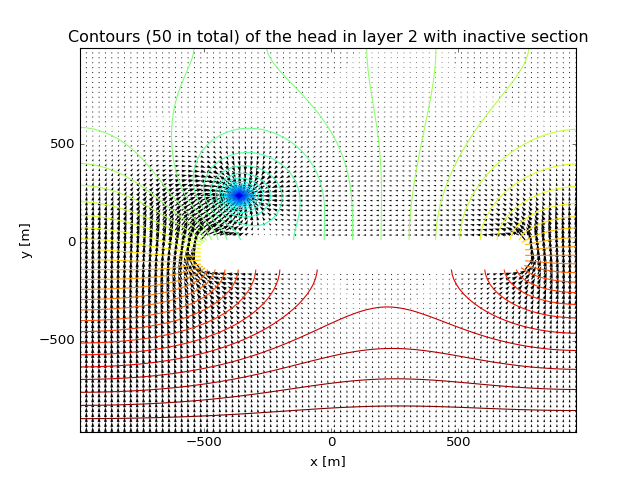

In [7]:
xm = 0.5 * (x[:-1] + x[1:])
ym = 0.5 * (y[:-1] + y[1:])

layer = 2 # contours for this layer
nc = 50   # number of contours in total

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Contours (%d in total) of the head in layer %d with inactive section" % (nc, layer))
plt.contour(xm, ym, Out.Phi[layer], nc)

#plt.quiver(X, Y, U, V) # show velocity vectors
X, Y, U, V = fdm_b.quivdata(Out, x, y, iz=0)
plt.quiver(X, Y, U, V)

* The white area is the aquifer part that was defined as inactive (impervious).
* The red trough is the well location.
* The two flanks and the front sides are closed (no FQ and no fixed head).
* The head at the back side is prescribed and maintained at zero.

Notice that the quidata function uses the computed flow arrays Out.Qx and Out.Qy.
We can verfiy the net inflow for all cells by printing or contouring the values.

In [8]:
print('\nSum of the net inflow over all cells is sum(Q) = {0:g} [m3/d]\n'.format(np.sum(Out.Q.ravel())))


Sum of the net inflow over all cells is sum(Q) = 4.80952e-10 [m3/d]



It can be seen that the sum of `Out.Q` over all cells is indeed zero (almost).

In [9]:
print('\nThe indivdual values for the top layer are shown here:')
print(np.round(Out.Q[:,:,0].T,2))


The indivdual values for the top layer are shown here:
[[ -0.     0.     0.  ]
 [  0.     0.    -0.  ]
 [  0.     0.     0.  ]
 [  0.    -0.    -0.  ]
 [ -0.    -0.     0.  ]
 [ -0.    -0.     0.  ]
 [  0.    -0.     0.  ]
 [ -0.    -0.    -0.  ]
 [ -0.     0.    -0.  ]
 [ -0.     0.     0.  ]
 [  0.     0.    -0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.     0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.    -0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.     0.  ]
 [  0.     0.    -0.  ]
 [ -0.     0.    -0.  ]
 [ -0.     0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.    -0.  ]
 [ -0.     0.     0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.     0.  ]
 [  0.     0.     0.  ]
 [ -0.     0.    -0.  ]
 [  0.     0.    -0.  ]
 [  0.    -0.     0.  ]
 [ -0.     0.    -0.  ]
 [ -0.     0.    -0.  ]
 [  0.    -0.     0.  ]
 [  0.  

The non-zero cells correspond to cells with prescribed flows or cells with prescribed heads, for which the netto inflows are computed using all computed and prescribed heads.

<IPython.core.display.Javascript object>


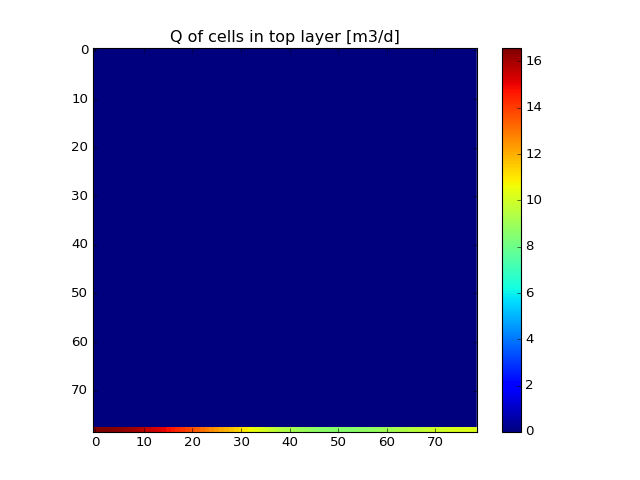

<IPython.core.display.Javascript object>


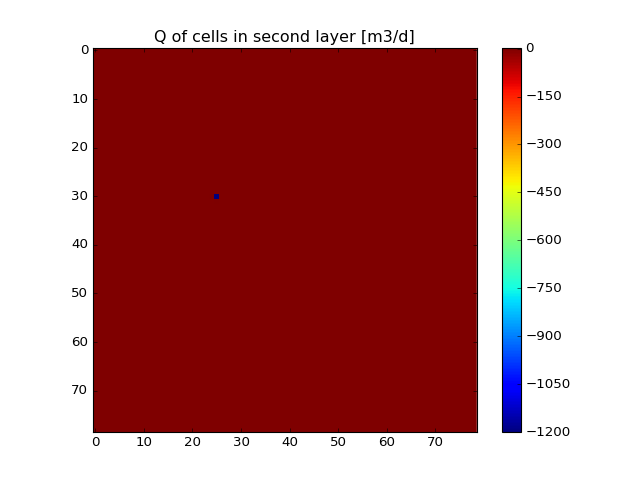

<IPython.core.display.Javascript object>


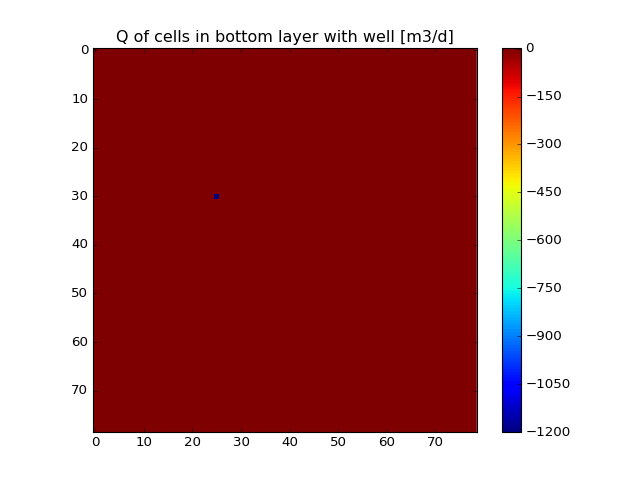

In [10]:
plt.figure(); plt.title('Q of cells in top layer [m3/d]')
plt.imshow(Out.Q[0, :, :], interpolation='None')
plt.colorbar()

plt.figure(); plt.title('Q of cells in second layer [m3/d]')
plt.imshow(Out.Q[1, :, :], interpolation='None')
plt.colorbar()

plt.figure(); plt.title('Q of cells in bottom layer with well [m3/d]')
plt.imshow(Out.Q[1, :, :], interpolation='None')
plt.colorbar()

Notice:

* that the coordinates are the cell numbers, the model is (79, 79, 3).
* the colorbars are different for each figure due to aut-selection.
* the flows in the 3rd layer with the well varies indeed between -1200 ( well extraction) and 0
* Further only the lower boundary is colored, i.e.non-zero, which is due to the fact that the heads are prescribed along that boundary and, therefore, the flows are computed. Positive values mean water is flowing from the outside world into the model.
* The zone with inactive cells are not visible, because the flow in those cells are zero as is the case for other cells with no prescribed flows or heads.

## Conclusion

We have extended the 3D steady state finite difference model to not only compute the heads but also the flows between the cells and the net inflow of the cells. The latter are for the computed heads as well as for the prescribed heads. Inactive cells will have a head `NaN` (Not a Number) and will have flow zero.

We also now have the convenience function to extract the flows at the center of all cells for visualization using the `matplotlib` function `quiver()`.